# Scatter correlation of the lightcones
Investigate the scatter correlation between Lx, Ysz; Ysz, Mgas; and Lx Mgas. Use Chandra T as all fits are from chandra T and it's directly comparable with observations.

In [8]:
import os
import pandas as pd
import numpy as np
import clusterfit as cf

data_dir = '/cosma8/data/do012/dc-he4/analysis'
all_data = []

for lc in range(1728):
    lc00 = f'{lc:04d}'
    f = f'{data_dir}/lc{lc00}/samples_in_lightcone{lc00}_duplicate_excision_outlier_excision.csv'

    if os.path.exists(f):
        df = pd.read_csv(f)
        df = df[[cf.COLUMNS['LX'], cf.COLUMNS['YSZ'], cf.COLUMNS['M'], cf.COLUMNS['T'], 'ObservedRedshift']]
        df['Lightcone'] = lc
        all_data.append(df)
        
# Concatenate all dataframes
df = pd.concat(all_data, ignore_index=True)

In [9]:
df

,LX0InRestframeWithoutRecentAGNHeating,Y5R500WithoutRecentAGNHeating,GasMass,ChandraT,ObservedRedshift,Lightcone
0,3.860932e+43,1.189383,2.942053e+12,1.161121,0.048034,0
1,6.563585e+43,7.968865,7.842610e+12,2.212505,0.017519,0
2,4.622958e+42,0.556380,1.103807e+12,0.859510,0.010826,0
3,4.072268e+44,29.496695,3.051145e+13,4.169577,0.021114,0
4,7.332445e+44,60.603631,5.531918e+13,5.543146,0.138401,0
...,...,...,...,...,...,...
1487355,1.213044e+44,26.495790,3.291663e+13,4.310905,0.101286,1727
1487356,1.571238e+44,27.374104,3.405050e+13,3.763483,0.095970,1727
1487357,2.257526e+44,25.873652,3.020221e+13,4.392961,0.070094,1727
1487358,1.971573e+44,56.651220,4.439278e+13,4.400429,0.107704,1727


In [24]:
%load_ext autoreload
%autoreload 2
import clusterfit as cf

# Read the concatenated scaling relation fits
f = '/cosma8/data/do012/dc-he4/analysis_all/concatenated_fit_all.csv'
df_fit = pd.read_csv(f)

for rel in ['LX-T', 'YSZ-T', 'M-T']:
    df_scat = pd.DataFrame({})
    yname, xname = cf.parse_relation_name(rel)

    all_scat = np.array([])
    lightcone = np.array([])
    for lc in range(1728):
        # Get the cluster data
        lc_mask = df['Lightcone'] == lc
        X = df[cf.COLUMNS[xname]][lc_mask].values
        Y = df[cf.COLUMNS[yname]][lc_mask].values
        z = df['ObservedRedshift'][lc_mask].values

        # Get the fit data    
        lc_mask = df_fit['Lightcone'] == lc
        A = df_fit['BestFitA'][lc_mask][df_fit['Relation']==rel].values[0]
        B = df_fit['BestFitB'][lc_mask][df_fit['Relation']==rel].values[0]

        # Get constants
        CX = cf.CONST[rel]['CX']
        CY = cf.CONST[rel]['CY']
        gamma = cf.CONST[rel]['gamma']

        # Calculate the 
        logY = np.log10(Y/CY)
        fit_logY = B * np.log10(X/CX) + np.log10(A) - np.log10(cf.E(z)) * gamma

        # Scatter
        scat = logY - fit_logY
        scat = scat[np.abs(scat) < 10]

        # Combine
        all_scat = np.concatenate((all_scat, scat))
        lightcone = np.concatenate((lightcone, np.full(np.shape(scat), lc)))
    
    df_scat['Scatter'] = all_scat
    df_scat['Lightcone'] = lightcone

    df_scat.to_csv(f'/cosma/home/do012/dc-he4/anisotropy-flamingo/data/analysis_all/scatter_{rel}.csv')


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/tmp/ipykernel_1944366/3872075151.py:33: RuntimeWarning: invalid value encountered in log10
  logY = np.log10(Y/CY)


In [13]:
df_scat

,Scatter,Lightcone
0,-0.008973,0.0
1,-0.099627,0.0
2,-0.204375,0.0
3,-0.010322,0.0
4,0.048006,0.0
...,...,...
1487355,0.009125,1727.0
1487356,0.130778,1727.0
1487357,-0.050013,1727.0
1487358,0.124070,1727.0


To read and plot, run this one only

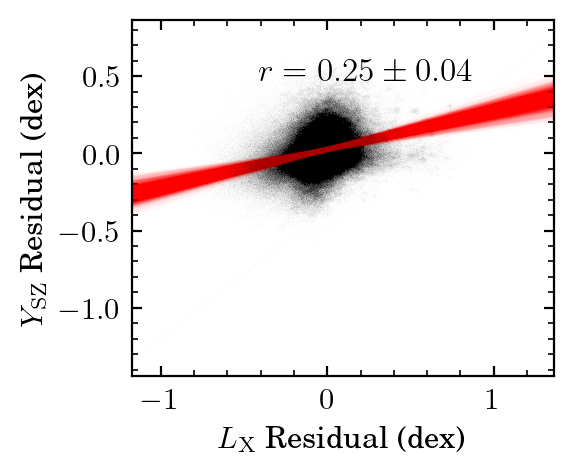

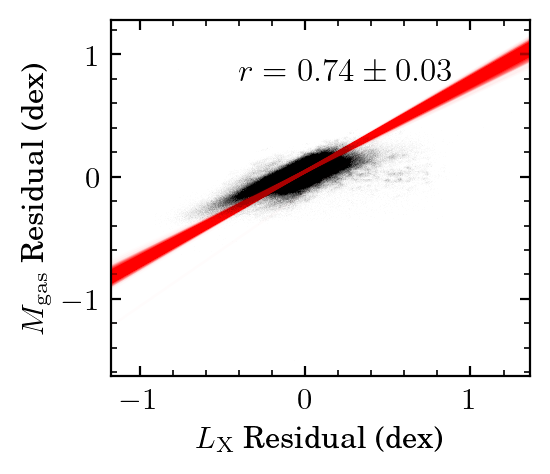

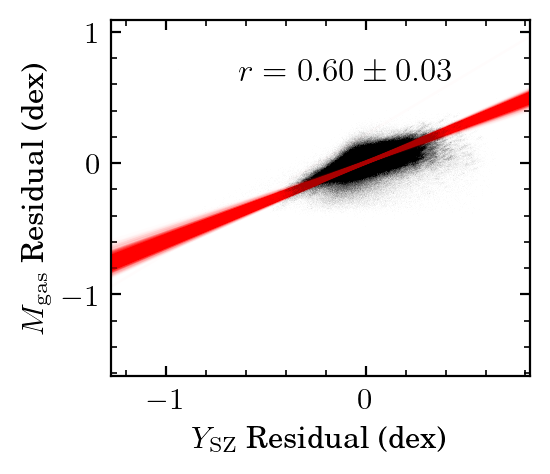

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from scipy.stats import pearsonr

# Set style for the plots
plt.style.use('./nice.mplstyle')

# Define axis labels and relation pairs
axis_labels = [
    ("$L_\\mathrm{X}$ Residual (dex)", "$Y_\\mathrm{SZ}$ Residual (dex)"),
    ("$L_\\mathrm{X}$ Residual (dex)", "$M_\\mathrm{gas}$ Residual (dex)"),
    ("$Y_\\mathrm{SZ}$ Residual (dex)", "$M_\\mathrm{gas}$ Residual (dex)")
]
relation_pairs = [('YSZ-T', 'LX-T'), ('M-T', 'LX-T'), ('M-T', 'YSZ-T')]

# Generate plots
for (rely, relx), (xlabel, ylabel) in zip(relation_pairs, axis_labels):
    # Load data for y and x relations
    df_scat_y = pd.read_csv(f'/cosma/home/do012/dc-he4/anisotropy-flamingo/data/analysis_all/scatter_{rely}.csv')
    df_scat_x = pd.read_csv(f'/cosma/home/do012/dc-he4/anisotropy-flamingo/data/analysis_all/scatter_{relx}.csv')

    x = df_scat_x['Scatter'].values
    y = df_scat_y['Scatter'].values

    # Create plot
    plt.figure(figsize=(3, 2.5), dpi=200)
    sns.scatterplot(x=x, y=y, alpha=0.01, color='black', s=0.1, edgecolor=None)  # High transparency scatter
    
    # Calculate Pearson correlation coefficient
    r_ls = []
    x_min, x_max = plt.xlim()  # Get current x-axis limits
    plt.xlim(x_min, x_max)     # fix it
    for lc in range(1728):
        df_scat_x_lc = df_scat_x[df_scat_x['Lightcone'] == lc]
        df_scat_y_lc = df_scat_y[df_scat_y['Lightcone'] == lc]
        
        x_lc = df_scat_x_lc['Scatter'].values
        y_lc = df_scat_y_lc['Scatter'].values 

        # Skip lightcones with insufficient data
        if len(x_lc) < 2 or len(y_lc) < 2:
            continue
        
        r, _ = pearsonr(x_lc, y_lc)  # Calculate the Pearson coefficient
        r_ls.append(r)              # Get a list of r

        # Extend the regression line beyond the data
        line_x = np.linspace(x_min, x_max, 100)
        line_y = r * (line_x - np.mean(x_lc)) + np.mean(y_lc)
        sns.lineplot(x=line_x, y=line_y, color='red', alpha=0.01)

    # Add labels
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

    # Legend
    r_ls = np.array(r_ls)       # note the median and standard deviation of r_pearson
    plt.legend([f"$r={np.median(r_ls):.2f} \pm {np.std(r_ls):.2f}$"], loc="upper left")  

    # Show plot
    plt.tight_layout()

    plt.savefig(f'./to_paper/scatter_corr_{rely}_{relx}.png')
    plt.show()
